In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6 as of

import tensorflow as tf

import gc


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





In [3]:
output_dir = 'output-files-bootstrap-test6-4d-1b'

#-------------
ndim = 4
n_boot_samples = 50
do_bootstrap = True
of_niter = 24
batch_size_setval = 400000
epochs_setval = 40
learning_rate_setval = 0.000500
#-------------


config_filename = '%s/config.txt' % output_dir

if not exists( config_filename ) :
    
    print('\n\n can not find config file:  %s' % config_filename )
    print('\n\n HALTING EXECUTION\n\n')
    sys.exit()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-files-bootstrap-test6-4d-1b/config.txt

2023-12-05 15:40:05.490148

ngen_train 4000000
ngen_true  400000
of_niter   24
ndim       4
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  400000
n_boot_samples  50
do_bootstrap  1


train_mu : [1.0, 0.0, -0.5, 0.5]
train_rho : [[0.3, -0.2, 0.1], [-0.5, 0.1], [0.7]]
train_sig : [1.0, 0.7, 1.1, 0.8]


true_mu : [0.8, 0.1, -0.6, 0.7]
true_rho : [[0.4, -0.3, 0.0], [-0.4, 0.2], [0.5]]
true_sig : [0.8, 0.6, 1.0, 0.6]


resolution : [0.4, 0.5, 0.6, 0.3]





In [4]:
last_bs_file_index = 0

for bsi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (output_dir, bsi)
    
    if exists(fname) and bsi > last_bs_file_index :
        
        last_bs_file_index = bsi
        
print("\n\n Last bootstrap index found is %d\n\n" % last_bs_file_index )





 Last bootstrap index found is 16




## Read in the samples from file

In [5]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')




 shape of train_pts:  (4000000, 4)
 shape of true_pts:   (400000, 4)





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

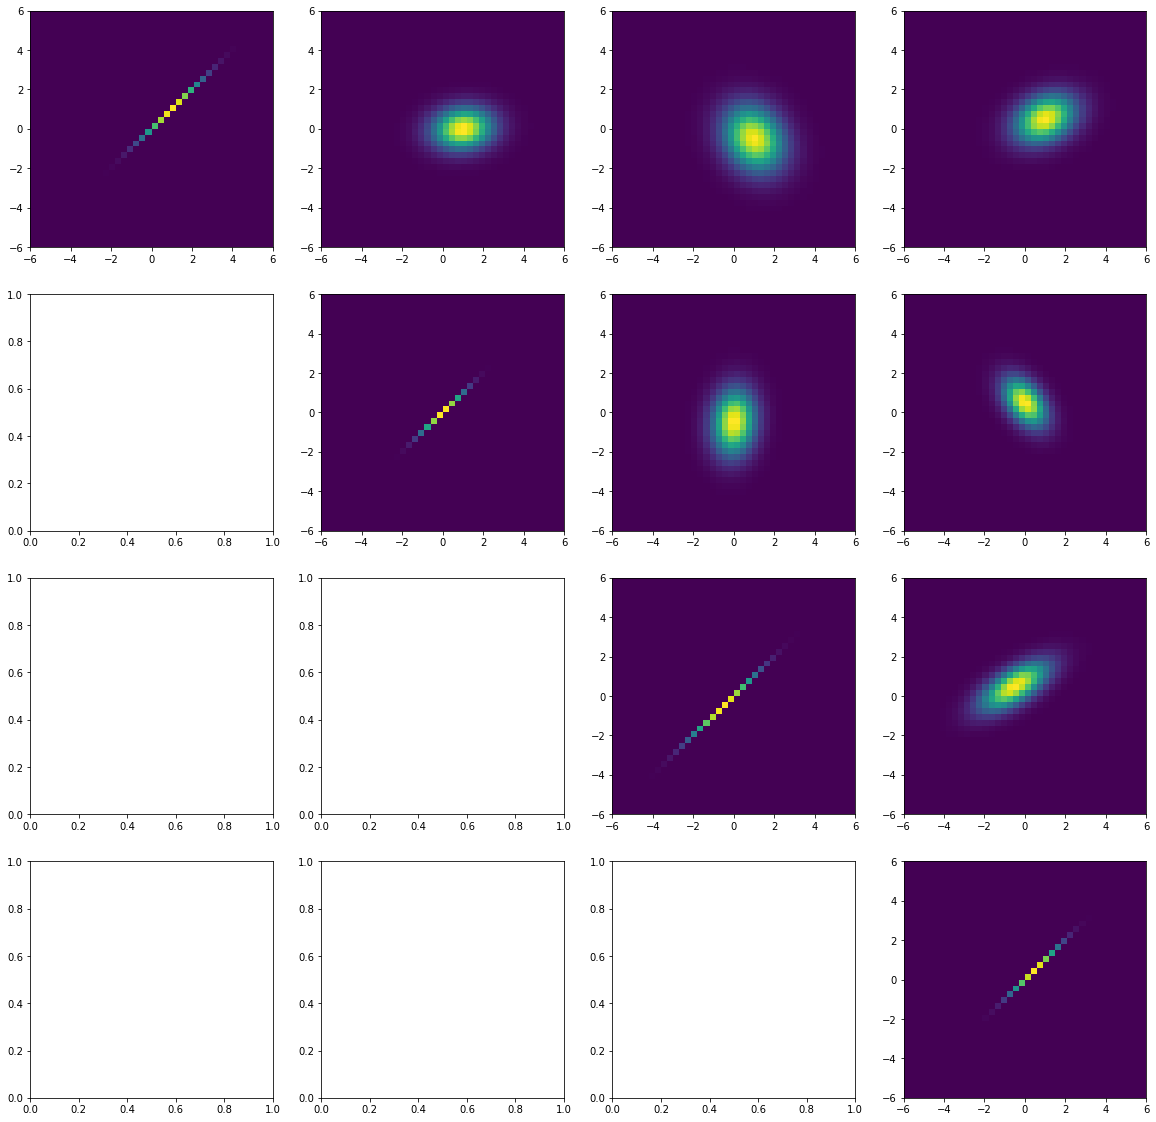

In [6]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

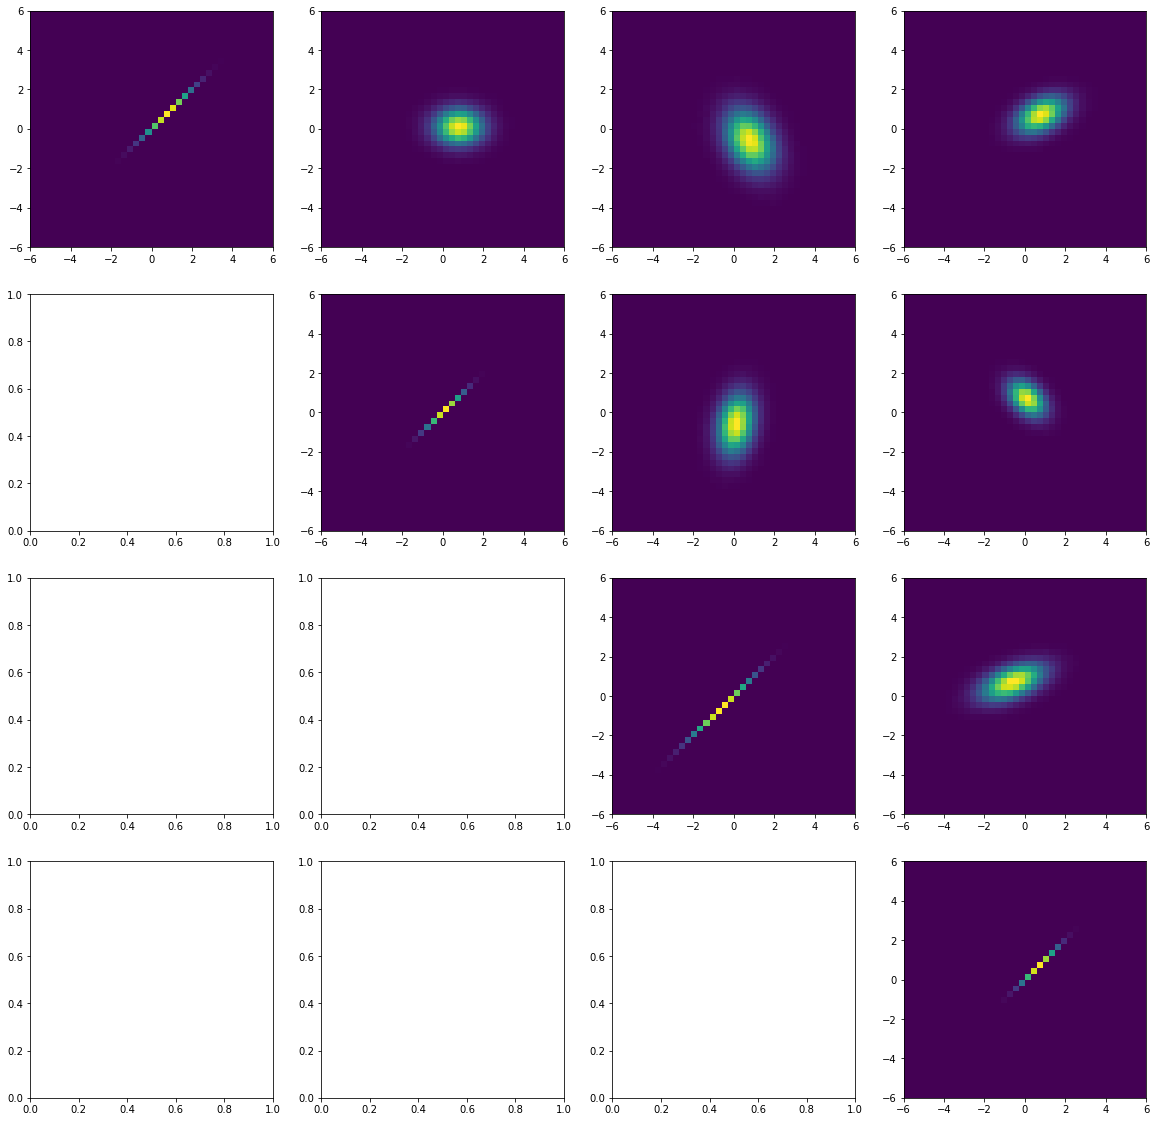

In [7]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

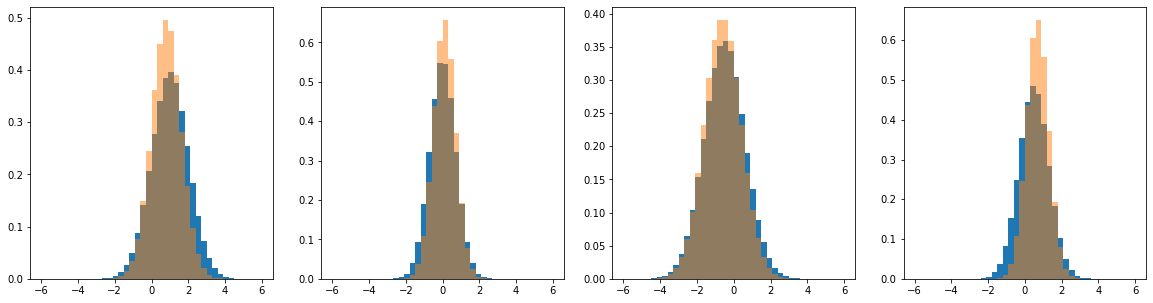

In [8]:
fig,ax = plt.subplots( 1, 4, figsize=(20,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [9]:
inputs = Input((4, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-05 18:32:11.132722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 18:32:11.150595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 18:32:11.150840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 18:32:11.154422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 18:32:11.154607: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [10]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Do the bootstrap samples in a loop

In [11]:

verbose = False



In [12]:
%%time

rng = np.random.default_rng()

for bi in range(last_bs_file_index+1,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        

        
    boot_of_return_dict = of.omnifold6( 
        train_both, boot_true_det_pts, of_niter, model, verbose, 
        batch_size_setval, learning_rate_setval, epochs_setval )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    #boot_final_push_weights_scaled = np.copy(boot_final_push_weights)
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

    

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_of_return_dict
    gc.collect()
    


 Creating bootstrap sample  17
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]


2023-12-05 18:32:14.988970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 18:32:14.992954: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0f16f6b270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 18:32:14.992967: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-05 18:32:14.996468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 18:32:15.084129: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 0s 685us/step
 weights_push at the beginning
[1.03157818 0.88969934 0.2211602  ... 1.40537834 0.81728071 0.37082487]
400/400 [==============================] - 0s 656us/step
 weights_push at the beginning
[0.92744522 0.67598641 0.10158371 ... 1.47658002 0.78555029 0.15144925]
400/400 [==============================] - 0s 669us/step
 weights_push at the beginning
[0.71649387 0.47989808 0.05633582 ... 1.44722623 0.74766663 0.06641387]
400/400 [==============================] - 0s 615us/step
 weights_push at the beginning
[0.55410869 0.34583581 0.03160831 ... 1.42644569 0.72220801 0.03130444]
400/400 [==============================] - 0s 660us/step
 weights_push at the beginning
[0.4225483  0.2558028  0.01972836 ... 1.39003017 0.71335209 0.017102  ]
400/400 [==============================] - 0s 660us/step
 weights_push at the beginning
[0.32320889 0.19530979 0.01181016 ... 1.3876142  0.70237608 0.0097709 ]
400/400 [==============================]

400/400 [==============================] - 0s 641us/step
 weights_push at the beginning
[8.98329583e-02 6.33103091e-02 2.31137157e-03 ... 2.00966269e+00
 6.39146649e-01 1.13097145e-03]
400/400 [==============================] - 0s 674us/step
 weights_push at the beginning
[8.06345394e-02 5.80500626e-02 1.92556127e-03 ... 2.00485834e+00
 6.19254880e-01 9.40382663e-04]
400/400 [==============================] - 0s 672us/step
 weights_push at the beginning
[7.41167697e-02 5.42938840e-02 1.55626376e-03 ... 2.00425523e+00
 6.07178809e-01 7.79736241e-04]
400/400 [==============================] - 0s 667us/step
 weights_push at the beginning
[6.86109855e-02 5.17077233e-02 1.38203004e-03 ... 2.01269744e+00
 5.96685358e-01 6.72761636e-04]
400/400 [==============================] - 0s 676us/step
 weights_push at the beginning
[6.45344241e-02 4.82804086e-02 1.18985769e-03 ... 1.96474770e+00
 5.82944558e-01 5.73057616e-04]
400/400 [==============================] - 0s 657us/step
 weights_push at t

400/400 [==============================] - 0s 655us/step


 bootstrap 19 final push weights scaled:
[9.33979055e-03 1.19339908e-02 4.56094751e-05 ... 1.41507690e-01
 4.81218008e-02 3.46707019e-05]

 Creating bootstrap sample  20
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
400/400 [==============================] - 0s 683us/step
 weights_push at the beginning
[1.04639077 0.91122031 0.24043529 ... 1.39535069 0.81572306 0.37317991]
400/400 [==============================] - 0s 661us/step
 weights_push at the beginning
[0.88104276 0.68295368 0.10762625 ... 1.53247488 0.782025   0.17080599]
400/400 [==============================] - 0s 632us/step
 weights_push at the beginning
[0.71466205 0.50298633 0.05906263 ... 1.59781628 0.78310193 0.08116176]
400/400 [==============================] - 0s 645us/step
 weights_push at the beginning
[0.57113942 0.38107042 0.03525423 ... 1.63932221 0.78438413 0.04169779]
400/400 [==============================] - 0s 664us/step
 weights_push at th

400/400 [==============================] - 0s 621us/step
 weights_push at the beginning
[1.08778397e-01 6.73422569e-02 2.88261210e-03 ... 2.17868222e+00
 8.24429234e-01 1.94654912e-03]
400/400 [==============================] - 0s 654us/step
 weights_push at the beginning
[9.23522470e-02 5.94258444e-02 2.36435975e-03 ... 2.16768026e+00
 7.99423949e-01 1.50759849e-03]
400/400 [==============================] - 0s 670us/step
 weights_push at the beginning
[7.86288038e-02 5.32921752e-02 1.95563476e-03 ... 2.14204687e+00
 7.70240991e-01 1.15675347e-03]
400/400 [==============================] - 0s 678us/step
 weights_push at the beginning
[6.89734873e-02 4.98084708e-02 1.63827209e-03 ... 2.12037860e+00
 7.52362742e-01 9.07363815e-04]
400/400 [==============================] - 0s 625us/step
 weights_push at the beginning
[6.05114534e-02 4.69702529e-02 1.41775513e-03 ... 2.09728425e+00
 7.29916728e-01 7.17044529e-04]
400/400 [==============================] - 0s 683us/step
 weights_push at t

400/400 [==============================] - 0s 641us/step
 weights_push at the beginning
[6.94583444e-02 3.36660782e-02 9.85508763e-04 ... 2.36301596e+00
 3.78490739e-01 3.63859446e-04]
400/400 [==============================] - 0s 633us/step
 weights_push at the beginning
[7.08198379e-02 3.34072057e-02 1.06124846e-03 ... 2.38896021e+00
 3.69233999e-01 3.79793929e-04]
400/400 [==============================] - 0s 683us/step


 bootstrap 22 final push weights scaled:
[6.70839317e-03 3.10485503e-03 1.01858090e-04 ... 2.38546802e-01
 3.41507759e-02 3.37926925e-05]

 Creating bootstrap sample  23
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
400/400 [==============================] - 0s 661us/step
 weights_push at the beginning
[1.11181748 0.87936133 0.24986985 ... 1.45834458 0.82029426 0.40545321]
400/400 [==============================] - 0s 666us/step
 weights_push at the beginning
[0.95306488 0.69719814 0.13349905 ... 1.56184303 0.79467908 0.18426554]
400/400 [=================

400/400 [==============================] - 0s 622us/step
 weights_push at the beginning
[0.16027154 0.19249431 0.00380803 ... 1.44548131 0.65246008 0.00283486]
400/400 [==============================] - 0s 661us/step
 weights_push at the beginning
[0.13449156 0.158448   0.00276424 ... 1.3898369  0.65171596 0.00193708]
400/400 [==============================] - 0s 661us/step
 weights_push at the beginning
[0.11506063 0.13483698 0.00203617 ... 1.37306604 0.65371269 0.00139239]
400/400 [==============================] - 0s 671us/step
 weights_push at the beginning
[9.86013960e-02 1.15501876e-01 1.54702582e-03 ... 1.33200545e+00
 6.51429302e-01 1.02045386e-03]
400/400 [==============================] - 0s 658us/step
 weights_push at the beginning
[8.57399066e-02 1.01126232e-01 1.17545026e-03 ... 1.30771630e+00
 6.52682832e-01 7.74830427e-04]
400/400 [==============================] - 0s 689us/step
 weights_push at the beginning
[7.63802722e-02 9.07632987e-02 9.30449277e-04 ... 1.31237357e+

400/400 [==============================] - 0s 672us/step
 weights_push at the beginning
[3.13470819e-02 1.05213336e-01 6.43697541e-04 ... 1.79044016e+00
 3.79727398e-01 1.33383891e-04]
400/400 [==============================] - 0s 665us/step
 weights_push at the beginning
[2.96666481e-02 1.06593439e-01 6.02600378e-04 ... 1.83292866e+00
 3.76103320e-01 1.18652877e-04]
400/400 [==============================] - 0s 595us/step
 weights_push at the beginning
[2.76645986e-02 1.09502271e-01 6.28622811e-04 ... 1.88584157e+00
 3.73593277e-01 1.09794118e-04]
400/400 [==============================] - 0s 690us/step
 weights_push at the beginning
[2.53702127e-02 1.08889786e-01 5.83048000e-04 ... 1.85289996e+00
 3.57538303e-01 9.80176807e-05]
400/400 [==============================] - 0s 643us/step


 bootstrap 25 final push weights scaled:
[2.41951456e-03 1.12049295e-02 5.93992077e-05 ... 1.88051628e-01
 3.44781764e-02 9.52592754e-06]

 Creating bootstrap sample  26
 weights_push at the beginning


400/400 [==============================] - 0s 652us/step
 weights_push at the beginning
[0.33780684 0.18338594 0.01164144 ... 1.84887872 0.67486361 0.00989704]
400/400 [==============================] - 0s 634us/step
 weights_push at the beginning
[0.28275458 0.14790406 0.00760132 ... 1.85869637 0.68227684 0.00625648]
400/400 [==============================] - 0s 622us/step
 weights_push at the beginning
[0.23618756 0.12009736 0.0051793  ... 1.85652174 0.69131968 0.00409745]
400/400 [==============================] - 0s 685us/step
 weights_push at the beginning
[0.20125168 0.10103307 0.00373818 ... 1.84218221 0.68840783 0.00289814]
400/400 [==============================] - 0s 662us/step
 weights_push at the beginning
[0.17182048 0.08534061 0.00273016 ... 1.79344544 0.68306456 0.00209232]
400/400 [==============================] - 0s 673us/step
 weights_push at the beginning
[1.49490666e-01 7.30763173e-02 2.07843704e-03 ... 1.72539801e+00
 6.72418589e-01 1.61074670e-03]
400/400 [======

400/400 [==============================] - 0s 640us/step
 weights_push at the beginning
[1.23133454e-01 5.08200548e-02 1.51262469e-03 ... 1.41415774e+00
 6.36012449e-01 2.97076761e-04]
400/400 [==============================] - 0s 670us/step
 weights_push at the beginning
[1.16937609e-01 4.67038954e-02 1.32095632e-03 ... 1.36491008e+00
 6.17949125e-01 2.50476859e-04]
400/400 [==============================] - 0s 666us/step
 weights_push at the beginning
[1.14762083e-01 4.45327337e-02 1.25065569e-03 ... 1.34672521e+00
 6.14021108e-01 2.26489168e-04]
400/400 [==============================] - 0s 669us/step
 weights_push at the beginning
[1.11935089e-01 4.23025688e-02 1.15731096e-03 ... 1.32761781e+00
 5.98542573e-01 2.01353406e-04]
400/400 [==============================] - 0s 643us/step
 weights_push at the beginning
[1.07890986e-01 3.96942760e-02 1.01069044e-03 ... 1.31347633e+00
 5.93996498e-01 1.71253662e-04]
400/400 [==============================] - 0s 632us/step
 weights_push at t

400/400 [==============================] - 0s 663us/step
 weights_push at the beginning
[0.52711605 0.35640496 0.0314475  ... 1.99625086 0.61375485 0.02650748]
400/400 [==============================] - 0s 654us/step
 weights_push at the beginning
[0.42027751 0.2884106  0.02207951 ... 2.03077389 0.58830229 0.01636996]
400/400 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.34210983 0.23690811 0.01617669 ... 2.05990496 0.56532952 0.01066973]
400/400 [==============================] - 0s 640us/step
 weights_push at the beginning
[0.28438773 0.19494139 0.01208157 ... 2.06045403 0.54435369 0.00717424]
400/400 [==============================] - 0s 599us/step
 weights_push at the beginning
[0.24100542 0.1634258  0.00945437 ... 2.06436266 0.53045905 0.00511914]
400/400 [==============================] - 0s 655us/step
 weights_push at the beginning
[0.20644244 0.13882173 0.00739002 ... 2.06245878 0.50758453 0.00377456]
400/400 [==============================]

400/400 [==============================] - 0s 717us/step
 weights_push at the beginning
[1.18364748e-01 5.59424852e-02 2.01138488e-03 ... 1.94700706e+00
 5.05579759e-01 7.20583539e-04]
400/400 [==============================] - 0s 647us/step
 weights_push at the beginning
[1.14329125e-01 5.25264297e-02 1.85941500e-03 ... 1.95715360e+00
 4.98672568e-01 6.42588687e-04]
400/400 [==============================] - 0s 655us/step
 weights_push at the beginning
[1.12649182e-01 5.11869369e-02 1.77741327e-03 ... 2.02700759e+00
 5.00138398e-01 5.94372367e-04]
400/400 [==============================] - 0s 647us/step
 weights_push at the beginning
[1.08983602e-01 4.84849195e-02 1.66613583e-03 ... 2.02199541e+00
 4.89216848e-01 5.39671328e-04]
400/400 [==============================] - 0s 660us/step
 weights_push at the beginning
[1.01655558e-01 4.46554058e-02 1.50444498e-03 ... 1.98298660e+00
 4.72444831e-01 4.68796414e-04]
400/400 [==============================] - 0s 626us/step
 weights_push at t

400/400 [==============================] - 0s 637us/step
 weights_push at the beginning
[0.57554844 0.47969008 0.03650138 ... 1.90954113 0.68303891 0.05333933]
400/400 [==============================] - 0s 667us/step
 weights_push at the beginning
[0.46450896 0.38222384 0.02375399 ... 1.95194544 0.6627085  0.03014055]
400/400 [==============================] - 0s 631us/step
 weights_push at the beginning
[0.37919446 0.30461137 0.01574424 ... 1.98159969 0.65490766 0.01790884]
400/400 [==============================] - 0s 627us/step
 weights_push at the beginning
[0.31402923 0.24565206 0.01073021 ... 1.99232879 0.65419796 0.01139004]
400/400 [==============================] - 0s 644us/step
 weights_push at the beginning
[0.2623845  0.2000027  0.0075426  ... 1.99118735 0.64249195 0.00757728]
400/400 [==============================] - 0s 674us/step
 weights_push at the beginning
[0.2215246  0.16686257 0.00525953 ... 2.00171913 0.62938474 0.00519326]
400/400 [==============================]

400/400 [==============================] - 0s 651us/step
 weights_push at the beginning
[1.24970245e-01 7.18184421e-02 1.31804682e-03 ... 2.50112740e+00
 4.34732460e-01 8.36108911e-04]
400/400 [==============================] - 0s 643us/step
 weights_push at the beginning
[1.15070617e-01 6.60265778e-02 1.12806708e-03 ... 2.50363490e+00
 4.19028758e-01 7.07872725e-04]
400/400 [==============================] - 0s 653us/step
 weights_push at the beginning
[1.07956550e-01 6.17460784e-02 1.05381639e-03 ... 2.47850516e+00
 4.13845127e-01 6.31409363e-04]
400/400 [==============================] - 0s 648us/step
 weights_push at the beginning
[1.01766859e-01 5.77958965e-02 9.72751080e-04 ... 2.50741748e+00
 4.10964627e-01 5.65004221e-04]
400/400 [==============================] - 0s 665us/step
 weights_push at the beginning
[9.50763187e-02 5.35017515e-02 8.44431053e-04 ... 2.50503459e+00
 3.94954409e-01 4.94806794e-04]
400/400 [==============================] - 0s 681us/step
 weights_push at t

400/400 [==============================] - 0s 632us/step
 weights_push at the beginning
[1.06855571 0.92980397 0.22977453 ... 1.55465841 0.79997867 0.39510462]
400/400 [==============================] - 0s 629us/step
 weights_push at the beginning
[0.86223897 0.74640777 0.11529877 ... 1.80368819 0.72354104 0.16718107]
400/400 [==============================] - 0s 650us/step
 weights_push at the beginning
[0.65109526 0.55489091 0.076751   ... 1.98114315 0.66512085 0.07869907]
400/400 [==============================] - 0s 702us/step
 weights_push at the beginning
[0.48510443 0.40929354 0.04710656 ... 2.11759618 0.60985813 0.03964651]
400/400 [==============================] - 0s 629us/step
 weights_push at the beginning
[0.37171657 0.32308907 0.02912851 ... 2.20973725 0.6002869  0.02248164]
400/400 [==============================] - 0s 642us/step
 weights_push at the beginning
[0.28729581 0.25634841 0.01804693 ... 2.26072453 0.5950143  0.01299596]
400/400 [==============================]

400/400 [==============================] - 0s 657us/step
 weights_push at the beginning
[1.56747755e-01 8.83402250e-02 1.60370856e-03 ... 2.21761579e+00
 6.37693540e-01 1.35989907e-03]
400/400 [==============================] - 0s 677us/step
 weights_push at the beginning
[1.46634875e-01 7.85989884e-02 1.28267131e-03 ... 2.19242634e+00
 6.30093085e-01 1.08782014e-03]
400/400 [==============================] - 0s 639us/step
 weights_push at the beginning
[1.38206909e-01 7.00749285e-02 1.05614057e-03 ... 2.14658566e+00
 6.26869425e-01 8.96775458e-04]
400/400 [==============================] - 0s 637us/step
 weights_push at the beginning
[1.28551933e-01 6.23897078e-02 8.62734873e-04 ... 2.08446201e+00
 6.11629374e-01 7.33548497e-04]
400/400 [==============================] - 0s 666us/step
 weights_push at the beginning
[1.23051013e-01 5.63417177e-02 7.01204259e-04 ... 2.05170655e+00
 6.34823671e-01 6.22183085e-04]
400/400 [==============================] - 0s 613us/step
 weights_push at t

400/400 [==============================] - 0s 658us/step


 bootstrap 38 final push weights scaled:
[7.61952126e-03 3.73641857e-03 2.67162981e-05 ... 1.69871234e-01
 4.16179773e-02 9.95392919e-06]

 Creating bootstrap sample  39
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
400/400 [==============================] - 0s 672us/step
 weights_push at the beginning
[1.0811882  0.96607566 0.26614341 ... 1.55035555 0.75759292 0.42587385]
400/400 [==============================] - 0s 676us/step
 weights_push at the beginning
[0.92017985 0.75517721 0.1337057  ... 1.82022391 0.63456971 0.20083497]
400/400 [==============================] - 0s 672us/step
 weights_push at the beginning
[0.72452197 0.57838169 0.07521394 ... 1.90692218 0.61601284 0.09580111]
400/400 [==============================] - 0s 652us/step
 weights_push at the beginning
[0.56593528 0.44502979 0.04411792 ... 1.88652825 0.60991437 0.04822533]
400/400 [==============================] - 0s 641us/step
 weights_push at th

400/400 [==============================] - 0s 667us/step
 weights_push at the beginning
[0.16494437 0.08483655 0.00397898 ... 1.67378676 0.65449951 0.00296959]
400/400 [==============================] - 0s 679us/step
 weights_push at the beginning
[0.1477708  0.07481447 0.00305412 ... 1.66079131 0.63565787 0.00230537]
400/400 [==============================] - 0s 658us/step
 weights_push at the beginning
[0.13344033 0.06810374 0.00248209 ... 1.66636984 0.63232489 0.0018593 ]
400/400 [==============================] - 0s 646us/step
 weights_push at the beginning
[1.18767576e-01 6.19912321e-02 1.97950101e-03 ... 1.67475472e+00
 6.13000841e-01 1.49392693e-03]
400/400 [==============================] - 0s 617us/step
 weights_push at the beginning
[1.08919551e-01 5.80462284e-02 1.68005180e-03 ... 1.67668411e+00
 6.05469508e-01 1.25151185e-03]
400/400 [==============================] - 0s 647us/step
 weights_push at the beginning
[1.00542572e-01 5.43007293e-02 1.45863490e-03 ... 1.65736316e+

400/400 [==============================] - 0s 649us/step
 weights_push at the beginning
[8.42858971e-02 6.72876423e-02 4.28367328e-04 ... 1.69042945e+00
 6.08797000e-01 3.44935678e-04]
400/400 [==============================] - 0s 654us/step
 weights_push at the beginning
[8.21176318e-02 6.55802178e-02 3.96930545e-04 ... 1.65217174e+00
 5.81912084e-01 3.09781126e-04]
400/400 [==============================] - 0s 650us/step


 bootstrap 41 final push weights scaled:
[7.89688378e-03 6.29627811e-03 3.72312319e-05 ... 1.64412843e-01
 5.67816757e-02 2.75227413e-05]

 Creating bootstrap sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
400/400 [==============================] - 0s 678us/step
 weights_push at the beginning
[1.03256428 0.98654318 0.25074044 ... 1.45754731 0.77262378 0.39759964]
400/400 [==============================] - 0s 675us/step
 weights_push at the beginning
[0.83233051 0.79566408 0.12419533 ... 1.63865963 0.64728262 0.19001781]
400/400 [=================

400/400 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.17087915 0.17701873 0.00382399 ... 1.76408056 0.5255028  0.0042429 ]
400/400 [==============================] - 0s 627us/step
 weights_push at the beginning
[0.14568869 0.15047205 0.00273829 ... 1.75337887 0.50821409 0.00289556]
400/400 [==============================] - 0s 629us/step
 weights_push at the beginning
[0.1277348  0.13101148 0.00201492 ... 1.76777861 0.48870494 0.0020468 ]
400/400 [==============================] - 0s 664us/step
 weights_push at the beginning
[1.13761069e-01 1.16066198e-01 1.53870863e-03 ... 1.76506223e+00
 4.71384114e-01 1.51848985e-03]
400/400 [==============================] - 0s 694us/step
 weights_push at the beginning
[1.03130326e-01 1.03441939e-01 1.17901506e-03 ... 1.76003002e+00
 4.53114359e-01 1.14204562e-03]
400/400 [==============================] - 0s 641us/step
 weights_push at the beginning
[9.47176261e-02 9.42232334e-02 9.81291784e-04 ... 1.77060727e+

400/400 [==============================] - 0s 696us/step
 weights_push at the beginning
[6.99528788e-02 4.30429374e-02 8.94406498e-04 ... 1.71433542e+00
 4.44723053e-01 8.46526204e-04]
400/400 [==============================] - 0s 628us/step
 weights_push at the beginning
[6.48262623e-02 3.91816762e-02 7.32637223e-04 ... 1.65651103e+00
 4.31366052e-01 7.20326398e-04]
400/400 [==============================] - 0s 628us/step
 weights_push at the beginning
[6.34265594e-02 3.80365243e-02 6.85599742e-04 ... 1.69879620e+00
 4.34100822e-01 6.81512567e-04]
400/400 [==============================] - 0s 633us/step
 weights_push at the beginning
[6.15415669e-02 3.66611103e-02 6.04140859e-04 ... 1.67540856e+00
 4.29320625e-01 6.34865527e-04]
400/400 [==============================] - 0s 673us/step


 bootstrap 44 final push weights scaled:
[6.16570920e-03 3.63468716e-03 5.68323621e-05 ... 1.67325923e-01
 4.40331379e-02 6.04913785e-05]

 Creating bootstrap sample  45
 weights_push at the beginning


400/400 [==============================] - 0s 673us/step
 weights_push at the beginning
[0.29568695 0.19946388 0.01347724 ... 2.02123278 0.67438681 0.01667477]
400/400 [==============================] - 0s 648us/step
 weights_push at the beginning
[0.23683206 0.16547747 0.00918704 ... 2.00698507 0.68210118 0.01110828]
400/400 [==============================] - 0s 622us/step
 weights_push at the beginning
[0.19203918 0.13957408 0.00652546 ... 1.98129056 0.6820576  0.0077479 ]
400/400 [==============================] - 0s 637us/step
 weights_push at the beginning
[0.16145888 0.12073205 0.00472205 ... 1.95401648 0.68189823 0.00566228]
400/400 [==============================] - 0s 650us/step
 weights_push at the beginning
[0.13658793 0.10467774 0.00352512 ... 1.92223993 0.65887242 0.00422043]
400/400 [==============================] - 0s 627us/step
 weights_push at the beginning
[0.11807916 0.09227668 0.00270988 ... 1.91603045 0.64148324 0.00324536]
400/400 [==============================]

400/400 [==============================] - 0s 683us/step
 weights_push at the beginning
[1.14901393e-01 9.20393867e-02 7.44766141e-04 ... 1.57717291e+00
 4.31237139e-01 9.34367693e-04]
400/400 [==============================] - 0s 671us/step
 weights_push at the beginning
[1.13598751e-01 9.26920861e-02 6.89257029e-04 ... 1.59770363e+00
 4.28690336e-01 8.86116580e-04]
400/400 [==============================] - 0s 707us/step
 weights_push at the beginning
[1.09045590e-01 9.15509942e-02 6.17970850e-04 ... 1.59418629e+00
 4.26919076e-01 8.25871358e-04]
400/400 [==============================] - 0s 638us/step
 weights_push at the beginning
[1.04010637e-01 8.99270695e-02 5.62550109e-04 ... 1.58505012e+00
 4.18746519e-01 7.87823776e-04]
400/400 [==============================] - 0s 622us/step
 weights_push at the beginning
[9.94943134e-02 8.83177564e-02 5.20228960e-04 ... 1.54974025e+00
 4.11559956e-01 7.56302966e-04]
400/400 [==============================] - 0s 627us/step


 bootstrap 47 fi

400/400 [==============================] - 0s 639us/step
 weights_push at the beginning
[0.38481111 0.26933015 0.01549863 ... 1.66935232 0.68482185 0.01896652]
400/400 [==============================] - 0s 621us/step
 weights_push at the beginning
[0.31095033 0.21947972 0.00992877 ... 1.67792097 0.67493126 0.01194358]
400/400 [==============================] - 0s 642us/step
 weights_push at the beginning
[0.25275606 0.18167051 0.00650964 ... 1.66359826 0.66649817 0.00783495]
400/400 [==============================] - 0s 675us/step
 weights_push at the beginning
[0.21116139 0.15577255 0.00444888 ... 1.64862796 0.66323004 0.00540698]
400/400 [==============================] - 0s 657us/step
 weights_push at the beginning
[0.17947949 0.13611954 0.00313713 ... 1.63241438 0.6576007  0.00390187]
400/400 [==============================] - 0s 661us/step
 weights_push at the beginning
[0.15318356 0.12020553 0.00225275 ... 1.59135994 0.64263114 0.00287923]
400/400 [==============================]